In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
# import csv's from dataset/train.csv and dataset/test.csv
train = pd.read_csv('dataset/train.csv')
# We only want the 'title' and 'label' columns, title is the text and label is the category (1 is unreliable, 0 is reliable)
train = train[['title', 'label']]
# remove all rows with NaN values
train = train.dropna()
# Drop empty strings
train = train[train['title'] != '']

In [2]:
# split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(train['title'], train['label'], test_size=0.2, random_state=42)

In [3]:
# Load glove embeddings
glove_embeddings = {}
print("Loading glove embeddings")
with open('glove.6B.100d.txt', 'r') as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_embeddings[word] = vector

Loading glove embeddings


400000it [00:08, 47669.26it/s]


In [4]:
from transform_dataset import apply_features
train_features, train_names = apply_features(X_train, glove_embeddings)
test_features, test_names = apply_features(X_test, glove_embeddings)

# put features into new dataframes with the names of the features as the columns
X_train = pd.DataFrame(train_features, columns=train_names)
X_test = pd.DataFrame(test_features, columns=test_names)

  1%|          | 119/16193 [00:58<2:06:19,  2.12it/s]/home/ryan/RPI/F24/SenseComp/project/transform_dataset.py:68: RuntimeWarning: invalid value encountered in scalar divide
  cos_sim = np.dot(embedding, net_dir) / (np.linalg.norm(embedding) * np.linalg.norm(net_dir))
100%|██████████| 4049/4049 [32:55<00:00,  2.05it/s]


In [5]:
# Fill in NaN values with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
dropped_features = {'sneu', 'FairnessVirtue', 'report_verbs', 'num_dates', 'NNS', 'AuthorityVirtue', 'JJS', 'vadneu', 'VB', '``', '--', 'WP$', 'LS', '(', 'factives', 'IngroupVice', 'AuthorityVice', 'lix', 'wneu', 'FairnessVice', 'wpos', 'positive_opinion_words', 'RB', 'FW', 'VBP', 'avg_wordlen', 'PurityVice', 'HarmVirtue', 'EX', 'SYM', '$', 'PDT', 'allpunc', 'vadneg', 'implicatives', 'UH', 'WRB', 'white-collar/blue-collar', 'assertatives', 'JJR', 'RP', ',', 'RBR', 'vadpos', 'MD', 'IngroupVirtue', '.', 'num_locations', 'male/female stereotypes', ':', 'VBD', "''", ')', 'POS', 'WDT', 'HarmVice', 'hedges', 'PRP', 'VBN', 'PurityVirtue', 'RBS', 'VBG', 'MoralityGeneral', 'sneg'}
X_train = X_train.drop(list(dropped_features), axis=1)
X_test = X_test.drop(list(dropped_features), axis=1)

In [6]:
# save X_train, X_test, y_train, y_test to csv files
X_train.to_csv('dataset/X_train.csv', index=False)
X_test.to_csv('dataset/X_test.csv', index=False)
y_train.to_csv('dataset/y_train.csv', index=False)
y_test.to_csv('dataset/y_test.csv', index=False)

Accuracy:  0.8824401086688071
Confusion Matrix:  [[1835  236]
 [ 240 1738]]
Classification Report:                precision    recall  f1-score   support

           0       0.88      0.89      0.89      2071
           1       0.88      0.88      0.88      1978

    accuracy                           0.88      4049
   macro avg       0.88      0.88      0.88      4049
weighted avg       0.88      0.88      0.88      4049

AUC:  0.9578089549994409


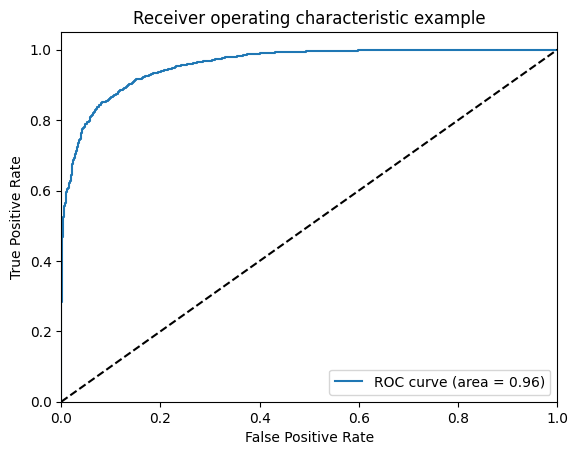

Best Threshold:  0.39469904


In [7]:

# run an xgboost model on the data and use all sklearn metrics then find a better probability threshold using the roc curve
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))
print("Classification Report: ", classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: ", roc_auc)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# find the best threshold
from sklearn.metrics import f1_score
f1_scores = []
for threshold in thresholds:
    y_pred_threshold = y_pred_proba > threshold
    f1_scores.append(f1_score(y_test, y_pred_threshold))
    
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best Threshold: ", best_threshold)

# save the model and the best threshold
import pickle
pickle.dump(model, open('model.pkl', 'wb'))
with open('threshold.txt', 'w') as f:
    f.write(str(best_threshold))
